Labor 8: Vektorquantisierung – Spracherkenner für Laute

In [1]:
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import scipy.io
import librosa
from scipy.cluster.vq import kmeans, vq
from mpl_toolkits.mplot3d import Axes3D

a: Berechnen Sie auf Basis der Mel-Cepstren von 180 Audiodatei, die von 10 verschiedenen Lauten
erzeugt wurden (a e f i l m n o s u) mittels dem K-Means-Algorithmus das zugehörige Codebook.
Welchen Wert für K wählen sie? Speichern Sie das Codebook geeignet ab. Plotten Sie anschließend
in der mfcc(1) – mfcc(2)-Ebene ihre Trainingsdaten und die ermittelten Codebook-Vektoren.
Hinweis: Die Mel-Cepstren können Sie der Datei mfccs_db.xlsx im Moodle-Kurs entnehmen. Zeile
1 -13 in der dort enthaltenen Matrix beschreiben die Mel-Koeffizienten (1-13). Zeile 14 enthält
einen Codewert für jeden Laut: (a : 1, e : 2, f : 3, i : 4, l : 5, m : 6, n : 7, o : 8, s : 9, u : 10

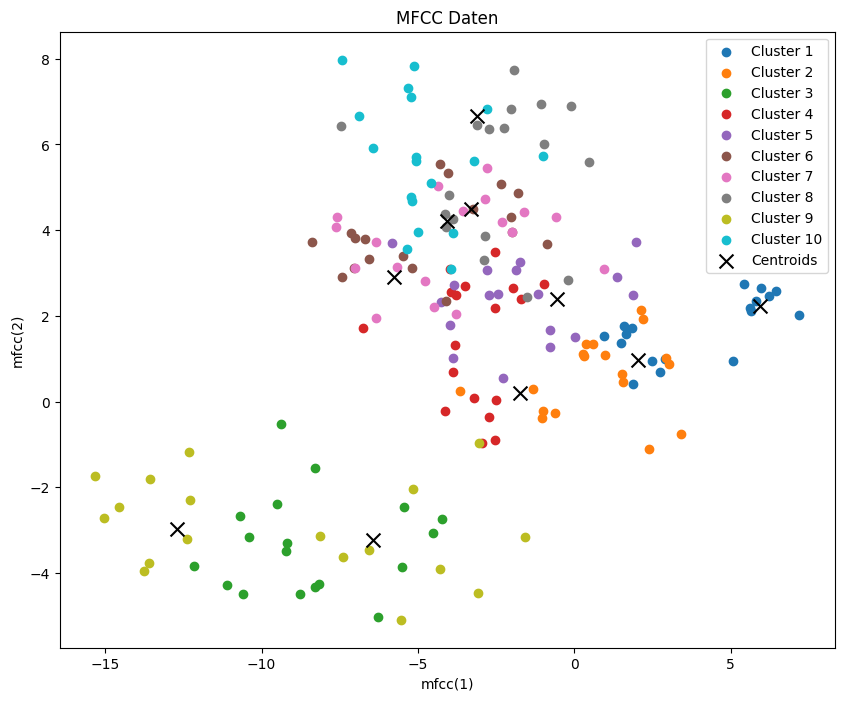

In [2]:
wb = openpyxl.load_workbook('mfcc_db.xlsx')
sheet = wb.active

data = []
for row in sheet.iter_rows(values_only=True):
    data.append([cell if cell is not None else 0 for cell in row])

data = np.array(data)
mfccs = data[:13, :].T
labels = data[13, :].astype(int)

K = 10

centroids, distortion = kmeans(mfccs, K)

plt.figure(figsize=(10, 8))

for i in range(1, K+1):
    cluster_data = mfccs[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')

plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='x', label='Centroids')

plt.xlabel('mfcc(1)')
plt.ylabel('mfcc(2)')
plt.legend()
plt.title('MFCC Daten')
plt.show()

np.savetxt('codebook.csv', centroids, delimiter=',')

Es werden die MFCC-Daten aus einer Excel-Datei geladen, darauf wird eine K-Means-Klusteranalyse mit 10 Clustern durchgeführt, diese Ergebnisse werden in einem Scatter-Plot visualisiert, anschließnend werden die Cluster-Zentroiden in einer CSV-Datei gespeichert.

b: Bestimmen die relative Anzahl der Traingsvektoren pro Voronoi-Bereich und erstellen Sie einen 3-
dimensionalen Plot aus Codebook-Vektoren und berechneter Häufigkeit. Interpretieren Sie das
Ergebnis.

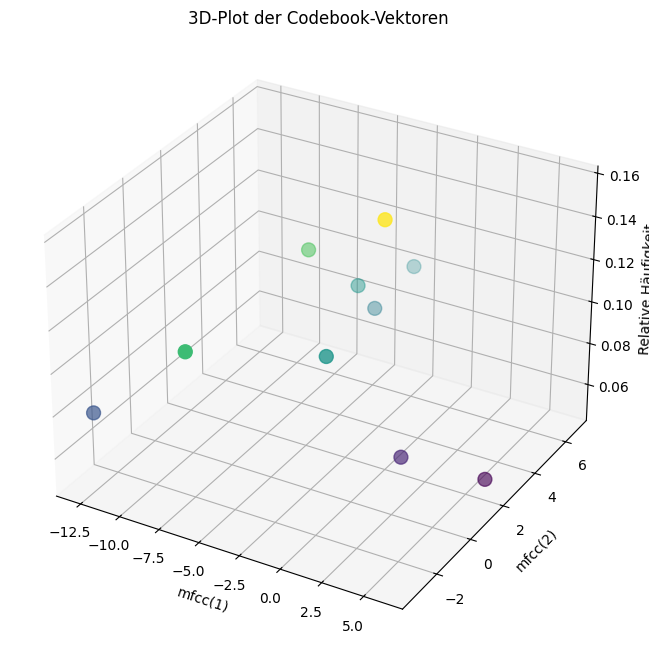

In [3]:
cluster_labels, _ = vq(mfccs, centroids)

unique, counts = np.unique(cluster_labels, return_counts=True)
relative_counts = counts / len(mfccs)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(centroids[:, 0], centroids[:, 1], relative_counts, c=relative_counts, cmap='viridis', s=100, marker='o')

ax.set_xlabel('mfcc(1)')
ax.set_ylabel('mfcc(2)')
ax.set_zlabel('Relative Häufigkeit')

plt.title('3D-Plot der Codebook-Vektoren')
plt.show()

Die MFCC-Daten werden anhand der zuvor berechneten Zentroiden quantisiert, die relative Häufigkeit jedes Clusters wird berechnet und diese wird in einem 3D-Scatter-Plot visualisiert, wobei einige Cluster mehr Datenpunkte enthalten als andere, was auf eine unterschiedliche Dichte der MFCC-Merkmale in den verschiedenen Clustern hinweist. Dies kann bei der Analyse von Audio- oder Sprachdaten helfen, indem es Bereiche identifiziert, die häufiger auftreten oder besondere Merkmale aufweisen.

c: Erstellen Sie jetzt eine Funktion die für einen Eingabe-Vektor (eingehendes Sprachsignal) den
Code-Vektor mit der geringsten Distanz bestimmt und den Index des Codevektors (=Position in
Codebook) als Wert zurückgibt.

In [4]:
def get_mfcc_from_wav(file_path):
    y, sr = librosa.load(file_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

def find_nearest_codevector(input_vector, centroids):
    distances = np.linalg.norm(centroids - input_vector, axis=1)
    nearest_index = np.argmin(distances)
    return nearest_index

nearest_index = find_nearest_codevector(get_mfcc_from_wav('suchmaschine.wav'), centroids)

print(f'Der Code-Vektor mit der geringsten Distanz: {nearest_index}')

Der Code-Vektor mit der geringsten Distanz: 2


Die mittleren MFCC-Werte einer WAV-Datei werden berechnet, der nächste Code-Vektor aus den zuvor berechneten Zentroiden wird ermittelt, und der Index des nächstgelegenen Zentroiden wird ausgegeben.

d: Bestimmen Sie anschließend die Zuordnung Codebook-Nummer zu Einzellaut, indem Sie die
Trainingsvektoren als Input verwenden und die bestimmte Code-Nummer ausgeben lassen.

In [5]:
laut = {i: [] for i in range(K)}

for label, cluster in zip(labels, cluster_labels):
    laut[cluster].append(label)

codebook = {}
for cluster, laute in laut.items():
    if laute:
        codebook[cluster] = max(set(laute), key=laute.count)

for codebook_no, laut in codebook.items():
    print(f"Codebook-Nummer {codebook_no}: Laut {laut}")

print(f'Der Code-Vektor mit der geringsten Distanz: {nearest_index}')
print(f'mit folgender Nummer des Lautes: {codebook[nearest_index]}')

Codebook-Nummer 0: Laut 8
Codebook-Nummer 1: Laut 6
Codebook-Nummer 2: Laut 9
Codebook-Nummer 3: Laut 2
Codebook-Nummer 4: Laut 8
Codebook-Nummer 5: Laut 1
Codebook-Nummer 6: Laut 6
Codebook-Nummer 7: Laut 3
Codebook-Nummer 8: Laut 4
Codebook-Nummer 9: Laut 1
Der Code-Vektor mit der geringsten Distanz: 2
mit folgender Nummer des Lautes: 9


Der Code ordnet jedem Cluster die am häufigsten vorkommenden Labels (Laute) zu und gibt die Cluster-Zuordnungen sowie den entsprechenden Laut für den nächstgelegenen Code-Vektor aus.

e: Erstellen Sie sich jetzt Audiodaten für die einzelnen Laute (a e f i l m n o s u). Die Länge der
Audiodaten sollte 30ms betragen und mit 8kHz gesampled werden. Erstellen Sie anschliessend
eine Funktion die für eine eingehende Audiodatei die Mel-Cepstren bestimmt. Die so bestimmten
Mel-Cepstren verwenden Sie um den Code-Vektor mit der niedrigsten Distanz zu bestimmen. Sie
haben jetzt ein Spracherkennungssystem für Laute.

C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=651
  warnings.warn(
C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=673
  warnings.warn(
C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=665
  warnings.warn(
C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=668
  warnings.warn(
C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=656
  warnings.warn(
C:\Users\dzaen\AppData\Local\Programs\Python\Python311\Lib\s

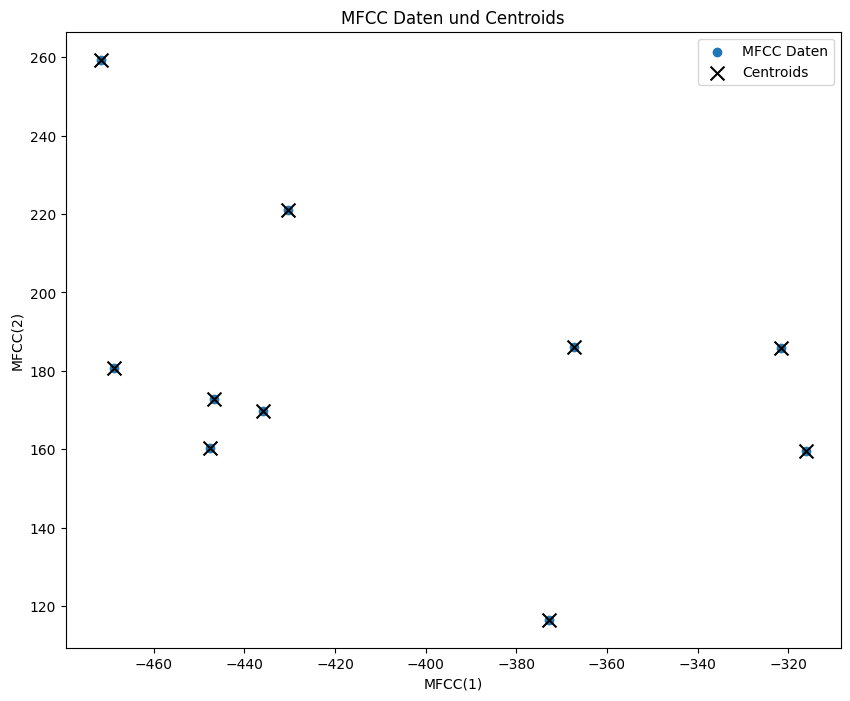

Der Code-Vektor mit der geringsten Distanz: 1
Der Laut ist: e


In [6]:
laute = ['a', 'e', 'f', 'i', 'l', 'm', 'n', 'o', 's', 'u']
mfcc_data = []
for laut in laute:
    file_path = f"{laut}.wav"
    mfcc_data.append(get_mfcc_from_wav(file_path))
mfcc_data = np.array(mfcc_data)

centroids, _ = kmeans(mfcc_data, K)

plt.figure(figsize=(10, 8))
plt.scatter(mfcc_data[:, 0], mfcc_data[:, 1], label='MFCC Daten')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='black', marker='x', label='Centroids')
plt.xlabel('MFCC(1)')
plt.ylabel('MFCC(2)')
plt.legend()
plt.title('MFCC Daten und Centroids')
plt.show()

nearest_index = find_nearest_codevector(get_mfcc_from_wav('suchmaschine.wav'), centroids)

print(f'Der Code-Vektor mit der geringsten Distanz: {nearest_index}')

laut_mapping = {i: laute[i] for i in range(len(laute))}
detected_laut = laut_mapping.get(nearest_index)

print(f'Der Laut ist: {detected_laut}')

Hier werden die MFCCs für die Laute 'a', 'e', 'f', 'i', 'l', 'm', 'n', 'o', 's', 'u' berechnet, nach durchführung von K-Means, werden anhand der MFCCs  in "suchmaschine.wav" de nächstgelegenen Laut bestimmt.